In [1]:
import os
import math
import json
import pytz
import requests
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
bucket = "https://alplakes-eawag.s3.eu-central-1.amazonaws.com"
bucket_key = bucket.split(".")[0].split("//")[1]

In [3]:
class boto3(object):
    def __init__(self):
        self.intialise = ""
    def upload_file(self, file, bucket, path):
        print(file, bucket, path)

s3 = boto3()

In [4]:
def calculate_rmse(dataset1, dataset2):
    """
    Calculate the Root Mean Square Error (RMSE) between two datasets,
    Interpolates dataset2 to match dataset1's timestamps before computing RMSE.
    Only interpolates within the range of dataset2's timestamps (no extrapolation).
    Computes RMSE only for the overlapping time period where both datasets have data.
    
    Args:
        dataset1 (dict): A dictionary with 'time' and 'values' lists for the first dataset.
        dataset2 (dict): A dictionary with 'time' and 'values' lists for the second dataset.

    Returns:
        float: The RMSE value.
    """
    # Convert time strings to datetime objects
    time1 = np.array([datetime.fromisoformat(t) for t in dataset1['time']])
    time2 = np.array([datetime.fromisoformat(t) for t in dataset2['time']])
    values2 = np.array(dataset2['values'], dtype=float)
    
    # Convert datetime objects to numerical timestamps (seconds since epoch)
    time1_numeric = np.array([t.timestamp() for t in time1])
    time2_numeric = np.array([t.timestamp() for t in time2])
    
    # Determine overlapping time period
    min_time = max(time1_numeric[0], time2_numeric[0])
    max_time = min(time1_numeric[-1], time2_numeric[-1])
    
    # Filter time1 to only include timestamps within the overlapping range
    valid_range = (time1_numeric >= min_time) & (time1_numeric <= max_time)
    time1_numeric_interp = time1_numeric[valid_range]
    
    if len(time1_numeric_interp) == 0:
        raise ValueError("No valid timestamps for interpolation in overlapping period.")
    
    # Perform linear interpolation, ignoring extrapolation
    interp_func = interp1d(time2_numeric, values2, kind='linear', bounds_error=False, fill_value=np.nan)
    interpolated_values2 = interp_func(time1_numeric_interp)
    
    # Remove NaN values (which occur due to out-of-bounds timestamps)
    valid_indices = ~np.isnan(interpolated_values2)
    aligned_values1 = np.array(dataset1['values'], dtype=float)[valid_range][valid_indices]
    aligned_values2 = interpolated_values2[valid_indices]
    
    if len(aligned_values1) == 0 or len(aligned_values2) == 0:
        raise ValueError("No valid matching data points after interpolation in overlapping period.")
    
    # Compute RMSE
    squared_differences = (aligned_values1 - aligned_values2) ** 2
    mse = np.mean(squared_differences)
    rmse = np.sqrt(mse)
    
    return rmse

In [5]:
def download_datalakes_data(datalakes_id, depth, start, stop):
    response = requests.get("https://api.datalakes-eawag.ch/datasetparameters?datasets_id={}".format(datalakes_id))
    if response.status_code != 200:
        raise ValueError("Failed to get datalakes parameters")
    parameters = response.json()

    time_axis = [p for p in parameters if p.get("parameters_id") == 1][0]["axis"]
    value_x = [p for p in parameters if p.get("parameters_id") == 5]
    if len(value_x) == 1 :
        value_axis = value_x[0]["axis"]
    elif "z" in value_x[0]["axis"]:
        value_axis = value_x[0]["axis"]
    else:
        value_xx = [p for p in value_x if "{}m".format(depth) in p["detail"]]
        if len(value_xx) == 1:
            value_axis = value_xx[0]["axis"]
        else:
            raise ValueError("Failed to find value parameter")
    if "z" in value_axis:
        d = [p for p in parameters if p.get("parameters_id") == 2]
        if len(d) == 0:
            d = [p for p in parameters if p.get("parameters_id") == 18]
        depth_axis = d[0]["axis"]

    response = requests.get("https://api.datalakes-eawag.ch/files?datasets_id={}".format(datalakes_id))
    if response.status_code != 200:
        raise ValueError("Failed to get datalakes files")
    files = response.json()
    files = [f for f in files if f["filetype"] == "json"]
    files = sorted(files, key=lambda x: datetime.strptime(x["maxdatetime"], "%Y-%m-%dT%H:%M:%S.%fZ"), reverse=True)
    file_ids = [files[0]["id"]]
    for i in range(20):
        if datetime.strptime(files[i]["mindatetime"], "%Y-%m-%dT%H:%M:%S.%fZ") > start:
            file_ids.append(files[ i +1]["id"])
        else:
            break
    time = []
    values = []

    for file_id in file_ids:
        response = requests.get("https://api.datalakes-eawag.ch/files/{}?get=raw".format(file_id))
        if response.status_code != 200:
            raise ValueError("Failed to get datalakes files")
        data = response.json()
        t = [datetime.fromtimestamp(d) for d in data[time_axis]]
        if "z" in value_axis:
            d_idx = min(range(len(data[depth_axis])), key=lambda i: abs(data[depth_axis][i] - depth))
            v = np.array(data[value_axis])[d_idx, :]
        else:
            v = np.array(data[value_axis])
        time = time + t
        values = values + v.tolist()

    df = pd.DataFrame({'time': time ,'value': values})
    df = df.dropna()
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by='time')
    df = df[(df['time'] >= start) & (df['time'] <= stop)]
    if len(df) < 10:
        raise ValueError("Not enough data to compare")
    time = df['time'].dt.strftime('%Y-%m-%dT%H:%M:%S+00:00').tolist()
    values = df['value'].tolist()
    return {"time": time, "values": values}

In [17]:
def download_zurich_police_data(station, start, stop):
    start = start + timedelta(days=1)
    stop = stop + timedelta(days=1)
    time = []
    values = []
    all_results = []
    limit = 1000
    for i in range(5):
        offset = i * limit
        url = (
            f"https://tecdottir.herokuapp.com/measurements/{station}"
            f"?startDate={start.strftime('%Y-%m-%d')}"
            f"&endDate={stop.strftime('%Y-%m-%d')}"
            f"&sort=timestamp_cet%20asc"
            f"&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code != 200:
            return False
        data = response.json()
        results = data.get("result", [])
        all_results.extend(results)

        if len(results) < limit:
            break
            
    for i in range(len(all_results)):
        try:
            if all_results[i]["values"]["water_temperature"]["status"] == "ok":
                time.append(datetime.strptime(all_results[i]["timestamp"], "%Y-%m-%dT%H:%M:%S.%fZ").replace(
                    tzinfo=timezone.utc).strftime('%Y-%m-%dT%H:%M:%S+00:00'))
                values.append(float(all_results[i]["values"]["water_temperature"]["value"]))
        except:
            pass
    
    return {"time": time, "values": values}

## 3D Model

In [18]:
lake = "greifensee"
model = "delft3d-flow"
api = "https://alplakes-api.eawag.ch"

# Collect model metadata
response = requests.get("{}/simulations/metadata/{}/{}".format(api, model, lake))
if response.status_code != 200:
    raise ValueError("Unable to access {}/simulations/metadata/{}/{}".format(api, model, lake))
lake_metadata = response.json()


# Get version of website metadata
branch = "master"
try:
    response = requests.get("https://raw.githubusercontent.com/eawag-surface-waters-research/alplakes-react/refs/heads/master/src/config.json")
    if response.status_code == 200:
        branch = response.json()["branch"]
except:
    print("Failed to find branch")

default_depth = 1
default_period = -6
response = requests.get("{}/static/website/metadata/{}/{}.json".format(bucket, branch, lake))
if response.status_code != 200:
    raise ValueError("Unable to access {}/static/website/metadata/{}/{}.json".format(bucket, branch, lake))
lake_info = response.json()
try:
    default_depth = lake_info["properties"]["default_depth"]
except:
    print("Failed to collect custom depth, using default of {}".format(default_depth))
    
# Performance
try:
    response = requests.get("{}/static/website/metadata/{}/performance.json".format(bucket, branch))
    performance_info = response.json()
    if model in performance_info and lake in performance_info[model]:
        live = performance_info[model][lake].copy()
        stop = datetime.now() - timedelta(days=1)
        stop = stop.replace(hour=23, minute=0, second=0, microsecond=0)
        start = stop - timedelta(days=10)
        rmse_total = []
        for location in live:
            for depth in live[location]["depth"]:
                try:
                    if live[location]["type"] == "datalakes":
                        live[location]["depth"][depth]["insitu"] = (
                                download_datalakes_data(live[location]["id"], live[location]["depth"][depth]["depth"], start, stop))
                    elif live[location]["type"] == "zurich_police":
                        live[location]["depth"][depth]["insitu"] = (
                                download_zurich_police_data(live[location]["id"], start, stop))
                    else:
                        raise ValueError("Unrecognised data source")
                    response = requests.get("{}/simulations/point/{}/{}/{}/{}/{}/{}/{}?variables=temperature".format(api, model, lake, start.strftime("%Y%m%d2300"), stop.strftime("%Y%m%d2300"), live[location]["depth"][depth]["depth"], live[location]["lat"], live[location]["lng"]))    
                    if response.status_code != 200:
                        raise ValueError("Failed to get model values")
                    out = response.json()
                    live[location]["depth"][depth]["model"] = {"time": out["time"], "values": out["variables"]["temperature"]["data"]}
                    rmse = calculate_rmse(live[location]["depth"][depth]["model"], live[location]["depth"][depth]["insitu"])
                    if isinstance(rmse, float) and not math.isnan(rmse):
                        rmse_total.append(rmse)
                        live[location]["depth"][depth]["rmse"] = round(rmse, 1)
                except:
                    raise
                    print("Failed to collect insitu")
        if len(rmse_total) > 0:
            lake_metadata["rmse"] = round(rmse_total[0], 1)
            print(live)
            with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
                temp_filename = temp_file.name
                json.dump(live, temp_file)
            s3.upload_file(temp_filename, bucket_key, "simulations/{}/cache/{}/performance.json".format(model, lake))
except:
    raise
    print("Live performance failed")

{'profiler': {'name': 'CTD Profiler', 'type': 'datalakes', 'id': 515, 'lat': 47.366, 'lng': 8.665, 'depth': {'surface': {'name': 'Surface', 'depth': 1, 'insitu': {'time': ['2025-04-29T00:09:27+00:00', '2025-04-29T06:09:32+00:00', '2025-04-29T12:09:21+00:00', '2025-04-29T18:09:23+00:00', '2025-04-30T00:09:18+00:00', '2025-04-30T06:09:24+00:00', '2025-04-30T12:09:19+00:00', '2025-04-30T18:09:29+00:00', '2025-05-01T00:09:27+00:00', '2025-05-01T06:09:25+00:00', '2025-05-01T12:09:18+00:00', '2025-05-01T18:09:14+00:00', '2025-05-02T00:09:27+00:00', '2025-05-02T06:09:29+00:00', '2025-05-02T12:09:19+00:00', '2025-05-02T18:09:20+00:00', '2025-05-03T00:09:27+00:00', '2025-05-03T06:09:15+00:00', '2025-05-03T12:09:29+00:00', '2025-05-03T18:09:19+00:00', '2025-05-04T00:09:16+00:00', '2025-05-04T06:09:21+00:00', '2025-05-04T12:09:19+00:00', '2025-05-04T18:09:24+00:00', '2025-05-05T00:09:15+00:00', '2025-05-05T00:09:15+00:00', '2025-05-05T06:09:25+00:00', '2025-05-05T12:09:17+00:00', '2025-05-05T18:0

## Simstrat

In [7]:
api = "https://alplakes-api.eawag.ch"

response = requests.get("{}/simulations/1d/metadata".format(api))
if response.status_code != 200:
    raise ValueError("Unable to access Simstrat metadata")
lakes = next((d for d in response.json() if d.get('model') == "simstrat"), {"lakes": []})["lakes"]

# Get version of website metadata
branch = "master"
try:
    response = requests.get("https://raw.githubusercontent.com/eawag-surface-waters-research/alplakes-react/refs/heads/master/src/config.json")
    if response.status_code == 200:
        branch = response.json()["branch"]
except:
    print("Failed to find branch")

response = requests.get("{}/static/website/metadata/{}/performance.json".format(bucket, branch))
if response.status_code == 200:
    performance_info = response.json()
    
lakes = [l for l in lakes if l["name"] == "aegeri"]    

for lake in lakes:
    try:
        if "simstrat" in performance_info and lake["name"] in performance_info["simstrat"]:
            live = performance_info["simstrat"][lake["name"]].copy()
            stop = datetime.now() - timedelta(days=1)
            stop = stop.replace(hour=23, minute=0, second=0, microsecond=0)
            start = stop - timedelta(days=10)
            rmse_total = []
            for location in live:
                for depth in live[location]["depth"]:
                    try:
                        if live[location]["type"] == "datalakes":
                            live[location]["depth"][depth]["insitu"] = download_datalakes_data(live[location]["id"], live[location]["depth"][depth]["depth"], start, stop)
                        else:
                            raise ValueError("Unrecognised data source")

                        response = requests.get("{}/simulations/1d/point/simstrat/{}/{}/{}/{}?variables=T".format(api, lake["name"], start.strftime("%Y%m%d2300"), stop.strftime("%Y%m%d2300"), live[location]["depth"][depth]["depth"]))    
                        if response.status_code != 200:
                            raise ValueError("Failed to get model values")
                        out = response.json()
                        live[location]["depth"][depth]["model"] = {"time": out["time"], "values": out["variables"]["T"]["data"]}
                        rmse = calculate_rmse(live[location]["depth"][depth]["model"], live[location]["depth"][depth]["insitu"])
                        if isinstance(rmse, float) and not math.isnan(rmse):
                            rmse_total.append(rmse)
                            live[location]["depth"][depth]["rmse"] = round(rmse, 1)
                    except:
                        print("Failed to collect insitu")
            if len(rmse_total) > 0:
                lake["rmse"] = round(rmse_total[0], 1)
                with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
                    temp_filename = temp_file.name
                    json.dump(live, temp_file)
                s3.upload_file(temp_filename, bucket_key, "simulations/simstrat/cache/{}/performance.json".format(lake["name"]))
    except:
        print("Failed to add performance for {}".format(lake["name"]))
    
    # Metadata
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
        temp_filename = temp_file.name
        json.dump(lake, temp_file)
    s3.upload_file(temp_filename, bucket_key, "simulations/simstrat/cache/{}/metadata.json".format(lake["name"]))
    os.remove(temp_filename)

/tmp/tmpm5dsa0kb alplakes-eawag simulations/simstrat/cache/aegeri/performance.json
/tmp/tmpry0fzo5s alplakes-eawag simulations/simstrat/cache/aegeri/metadata.json


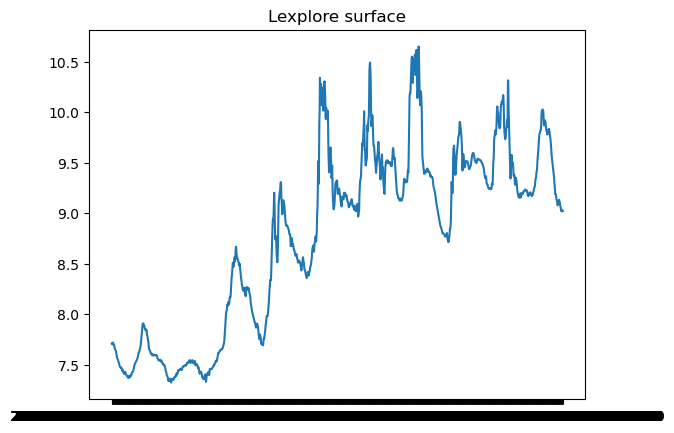

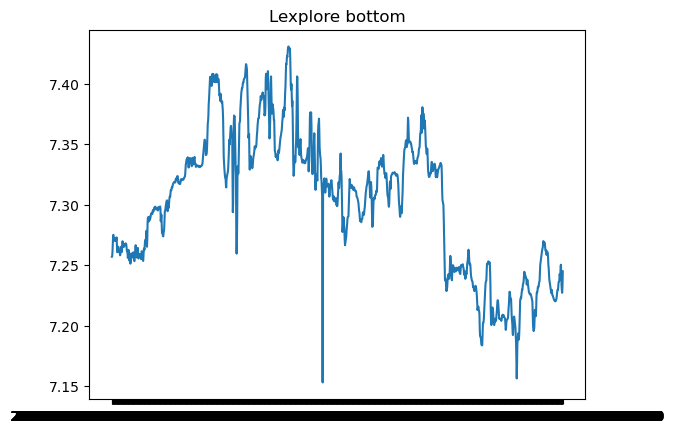

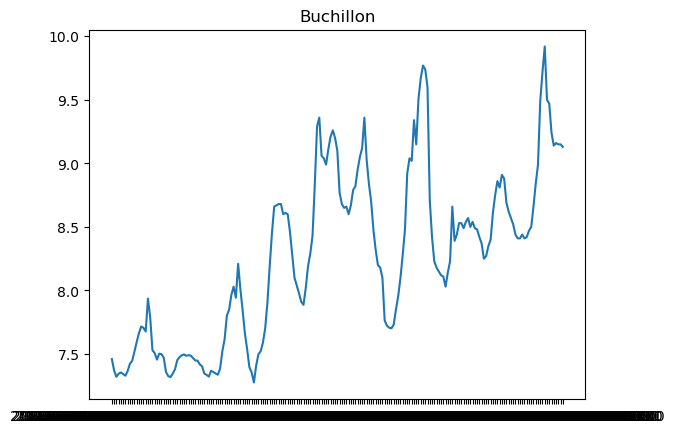

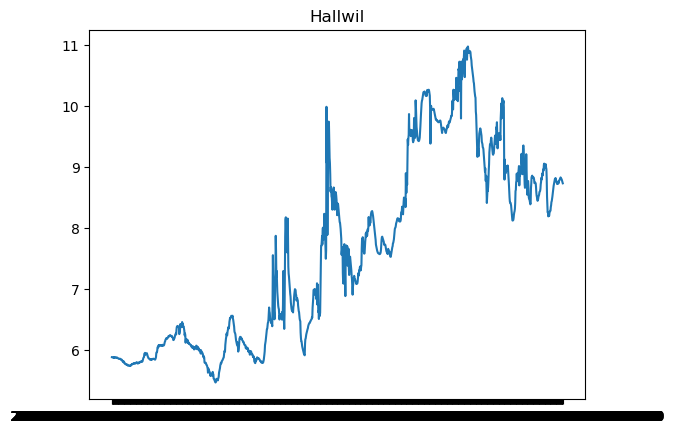

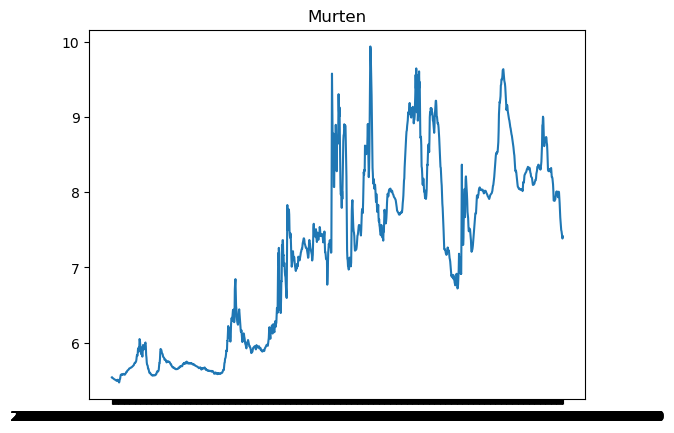

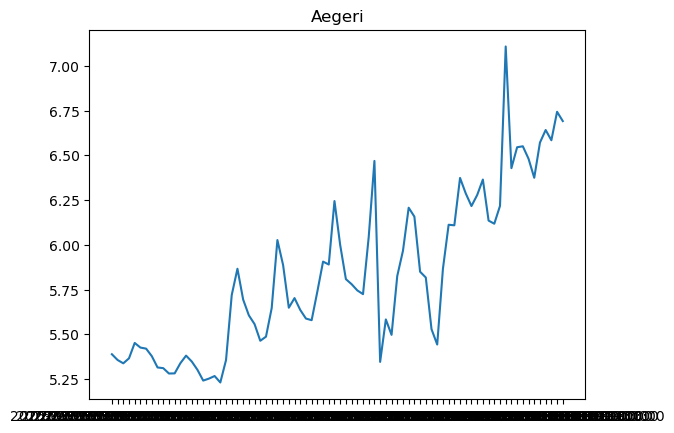

In [8]:
tests = [{"id": 448, "depth": 0.25, "name": "Lexplore surface"},
         {"id": 448, "depth": 90, "name": "Lexplore bottom"}, 
         {"id": 597, "depth": 1, "name": "Buchillon"},
         {"id": 1046, "depth": 0.5, "name": "Hallwil"}, 
         {"id": 956, "depth": 1, "name": "Murten"},
         {"id": 1077, "depth": 2, "name": "Aegeri"}
        ]

stop = datetime.now() - timedelta(days=1)
stop = stop.replace(hour=23, minute=0, second=0, microsecond=0)
start = stop - timedelta(days=10)

for test in tests:
    data = download_datalakes_data(test["id"], test["depth"], start, stop)
    plt.plot(data["time"], data["values"])
    plt.title(test["name"])
    plt.show()

## Combined

In [10]:
model_id = "zurich"
model = "delft3d-flow"
api = "https://alplakes-api.eawag.ch"

# Collect model metadata
response = requests.get("{}/simulations/metadata/{}/{}".format(api, model, lake))
if response.status_code != 200:
    raise ValueError("Unable to access {}/simulations/metadata/{}/{}".format(api, model, lake))
lake_metadata = response.json()


# Get version of website metadata
branch = "master"
try:
    response = requests.get("https://raw.githubusercontent.com/eawag-surface-waters-research/alplakes-react/refs/heads/master/src/config.json")
    if response.status_code == 200:
        branch = response.json()["branch"]
except:
    print("Failed to find branch")


response = requests.get("{}/static/website/metadata/{}/performance2.json".format(bucket, branch))
performance_info = response.json()

print(performance_info)



if model in performance_info and lake in performance_info[model]:
    live = performance_info[model][lake].copy()
    stop = datetime.now() - timedelta(days=1)
    stop = stop.replace(hour=23, minute=0, second=0, microsecond=0)
    start = stop - timedelta(days=10)
    rmse_total = []
    for location in live:
        for depth in live[location]["depth"]:
            try:
                if live[location]["type"] == "datalakes":
                    live[location]["depth"][depth]["insitu"] = (
                        download_datalakes_data(live[location]["id"], live[location]["depth"][depth]["depth"], start, stop))
                elif live[location]["type"] == "zurich_police":
                    live[location]["depth"][depth]["insitu"] = (
                        download_zurich_police_data(live[location]["id"], start, stop))
                else:
                    raise ValueError("Unrecognised data source")
                response = requests.get(
                    "{}/simulations/point/{}/{}/{}/{}/{}/{}/{}?variables=temperature"
                    .format(api, model, lake, start.strftime("%Y%m%d2300"), stop.strftime("%Y%m%d2300"),
                            live[location]["depth"][depth]["depth"], live[location]["lat"], live[location]["lng"]))
                if response.status_code != 200:
                    raise ValueError("Failed to get model values")
                out = response.json()
                live[location]["depth"][depth]["model"] = {"time": out["time"],
                                                           "values": out["variables"]["temperature"]["data"]}
                rmse = calculate_rmse(live[location]["depth"][depth]["model"],
                                      live[location]["depth"][depth]["insitu"])
                if isinstance(rmse, float) and not math.isnan(rmse):
                    rmse_total.append(rmse)
                    live[location]["depth"][depth]["rmse"] = round(rmse, 1)
            except Exception as e:
                print(e)
                print("Failed to collect insitu")
    if len(rmse_total) > 0:
        lake_metadata["rmse"] = round(rmse_total[0], 1)
        with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
            temp_filename = temp_file.name
            json.dump(live, temp_file)
        s3.upload_file(temp_filename, bucket_key,
                       "simulations/{}/cache/{}/performance.json".format(model, lake))

{'zurich': [{'name': 'Zürich Police - Tiefenbrunnen', 'type': 'lake-scrape', 'id': 'zurich_police_tiefenbrunnen', 'lat': 47.348139, 'lng': 8.561413, 'depth': [{'name': '1.0 m', 'depth': 1}], 'models': [{'type': 'deflt3d-flow', 'id': 'zurich'}, {'type': 'mitgcm', 'id': 'zurich'}, {'type': 'simstrat', 'id': 'lowerzurich'}]}, {'name': 'Zürich Police - Mythenquai', 'type': 'lake-scrape', 'id': 'zurich_police_mythenquai', 'lat': 47.348139, 'lng': 8.561413, 'depth': [{'name': '1.0 m', 'depth': 1}], 'models': [{'type': 'deflt3d-flow', 'id': 'zurich'}, {'type': 'mitgcm', 'id': 'zurich'}, {'type': 'simstrat', 'id': 'lowerzurich'}]}]}


In [127]:
def cache_performance(model_type, model_id, s3, bucket="https://alplakes-eawag.s3.eu-central-1.amazonaws.com", branch="master", api="https://alplakes-api.eawag.ch"):
    response = requests.get("{}/static/website/metadata/{}/performance2.json".format(bucket, branch))
    p = response.json()
    bucket_key = bucket.split(".")[0].split("//")[1]
    stop = datetime.now() - timedelta(days=1)
    stop = stop.replace(hour=23, minute=0, second=0, microsecond=0)
    start = stop - timedelta(days=10)
    
    for lake, lake_sensors in p.items():
        matching_sensors = [
            sensor for sensor in lake_sensors
            if any(model["type"] == model_type and model["id"] == model_id for model in sensor["models"])
        ]
        if matching_sensors:
            break
            
    if len(matching_sensors) == 0:
        return False
    
    rmse_total = []
    
    for sensor in matching_sensors:
        for depth in sensor["depth"]:
            try:
                if sensor["type"] == "datalakes":
                        depth["data"] = download_datalakes_data(sensor["id"], depth["depth"], start, stop)
                elif sensor["type"] == "lake-scrape":
                        depth["data"] = download_insitu_data(sensor["id"], start, stop)
                else:
                    raise ValueError("Unrecognised data source")
                days = (datetime.fromisoformat(depth["data"]["time"][-1]) - datetime.fromisoformat(depth["data"]["time"][0])).days
                if days < 5:
                    print("Insitu data doesnt cover a period of at least 5 days")
                    depth["data"] = False
                    continue
                for model in sensor["models"]:
                    if "data" not in model:
                        model["data"] = {}
                    model["data"][depth["name"]] = {}
                    try:
                        if model["type"] in ["mitgcm", "delft3d-flow"]:
                            model["data"][depth["name"]]["data"] = download_3d_model_data(api, model["type"], model["id"], depth["depth"], sensor["lat"], sensor["lng"], start, stop)
                        elif model["type"] in ["simstrat"]:
                            model["data"][depth["name"]]["data"] = download_1d_model_data(api, model["type"], model["id"], depth["depth"], start, stop)
                        else:
                            print("Unrecognised model")
                            continue
                    except Exception as e:
                        print("Failed for model {}".format(model["type"]))
                        print(e)
                    rmse = calculate_rmse(model["data"][depth["name"]]["data"], depth["data"])
                    if isinstance(rmse, float) and not math.isnan(rmse):
                        model["data"][depth["name"]]["rmse"] = round(rmse, 2)
                        if model["type"] == model_type and model["id"] == model_id:
                            rmse_total.append(rmse)
            except Exception as e:
                print("Failed for sensor {}".format(sensor["name"]))
                print(e)
    if len(rmse_total) > 0:
        with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_file:
            temp_filename = temp_file.name
            json.dump(matching_sensors, temp_file)
        s3.upload_file(temp_filename, bucket_key, "performance/{}.json".format(lake))
        return round(sum(rmse_total) / len(rmse_total), 1)
    else:
        return False
    

In [128]:
cache_performance("mitgcm", "zurich", s3, branch="mitgcm")

/tmp/tmpnhz13dwa alplakes-eawag performance/zurich.json


1.2

In [74]:
def download_insitu_data(station, start, stop):
    response = requests.get("https://alplakes-internal-api.eawag.ch/insitu/temperature/measured/{}/{}/{}".format(station, start.strftime('%Y%m%d'), stop.strftime('%Y%m%d')))
    if response.status_code != 200:
        raise ValueError("Failed to get insitu data")
    data = response.json()
    return {"time": data["time"], "values": data["variable"]["data"]}

In [86]:
def download_3d_model_data(api, model_type, model_id, depth, lat, lng, start, stop):
    response = requests.get(
        "{}/simulations/point/{}/{}/{}/{}/{}/{}/{}?variables=temperature"
        .format(api, model_type, model_id, start.strftime("%Y%m%d2300"), stop.strftime("%Y%m%d2300"),
                depth, lat, lng))
    if response.status_code != 200:
        raise ValueError("Failed to get model values")
    data = response.json()
    return {"time": data["time"], "values": data["variables"]["temperature"]["data"]}

In [76]:
def download_1d_model_data(api, model_type, model_id, depth, start, stop):
    response = requests.get("{}/simulations/1d/point/{}/{}/{}/{}/{}?variables=T".format(api, model_type, model_id, start.strftime("%Y%m%d2300"), stop.strftime("%Y%m%d2300"), depth))    
    if response.status_code != 200:
        raise ValueError("Failed to get model values")
    data = response.json()
    return {"time": data["time"], "values": data["variables"]["T"]["data"]}